# Model4: Comments classification using BERT

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [16]:
df1 = pd.read_csv('../../data/semeval2017_twitter/combined_sentiment_dataset.csv')
df2 = pd.read_csv('../../data/YouTube_Comments_Dataset/YoutubeCommentsDataSet.csv')

In [17]:
df1.head()

,text,label,split,sentiment
0,"""QT @user In the original draft of the 7th boo...",2,train,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,train,neutral
2,Sorry bout the stream last night I crashed out...,1,train,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,train,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,train,positive


In [18]:
df1['label'].value_counts()

label
1    27479
2    21043
0    11377
Name: count, dtype: int64

2 - positive; 1 - neutral; 0 - negative

In [19]:
df1 = df1[["text", "label"]]
df1.columns = ["Comment", "Sentiment"]

In [20]:
df2.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [23]:
df2["Sentiment"] = df2["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).infer_objects(copy=False)
df2["Sentiment"] = df2["Sentiment"].astype(int)

In [25]:
df = pd.concat([df1, df2], ignore_index=True)

## Visualizations

### Sentiment Distribution

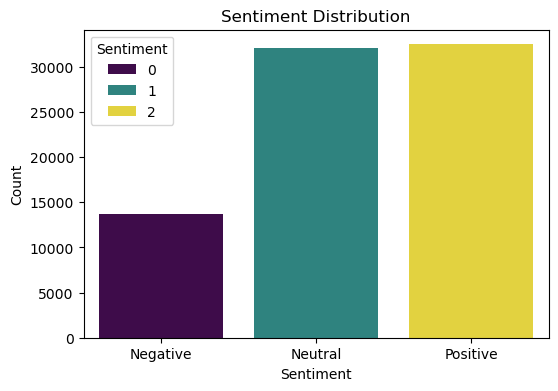

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Sentiment"], palette="viridis", hue = df["Sentiment"])
plt.xticks(ticks=[0, 1, 2], labels=["Negative", "Neutral", "Positive"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

There are much more less number of negative comments compared to positive and neutral comments.

### Word Cloud for Each Sentiment

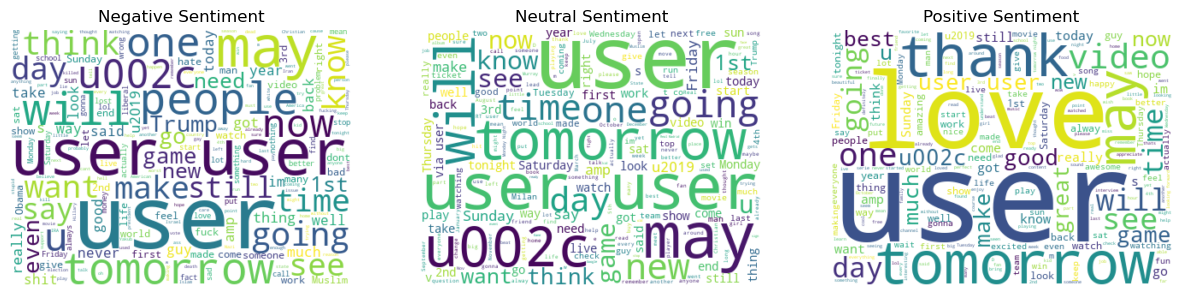

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
for sentiment, ax in zip(sentiment_labels.keys(), axes):
    text = " ".join(df[df["Sentiment"] == sentiment]["Comment"].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{sentiment_labels[sentiment]} Sentiment")
plt.show()

There are no significant differences between the word clouds of different sentiments. So it may be hard to classify the comments based on the words. Also there are a lot of "user" words so, try to remove them.

In [35]:
import re
def clean_comment(text):
    text = re.sub(r"@user", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"(^|\s)QT\s", "", text) 
    text = re.sub(r".*?:\s", "", text)  
    text = text.strip()
    return text

In [38]:
df["Comment"] = df["Comment"].astype(str)
cleaned_dataset = [clean_comment(text) for text in df["Comment"]]
df["Comment"] = cleaned_dataset

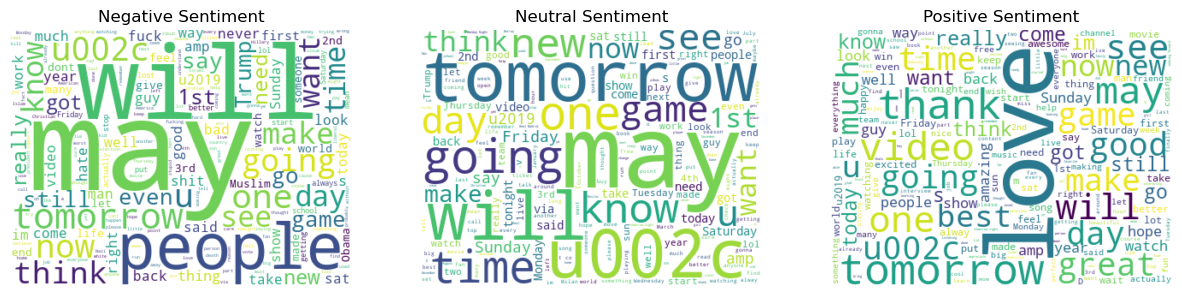

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
for sentiment, ax in zip(sentiment_labels.keys(), axes):
    text = " ".join(df[df["Sentiment"] == sentiment]["Comment"].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{sentiment_labels[sentiment]} Sentiment")
plt.show()

Now sentences are more clear and for model it will be easier to classify them.

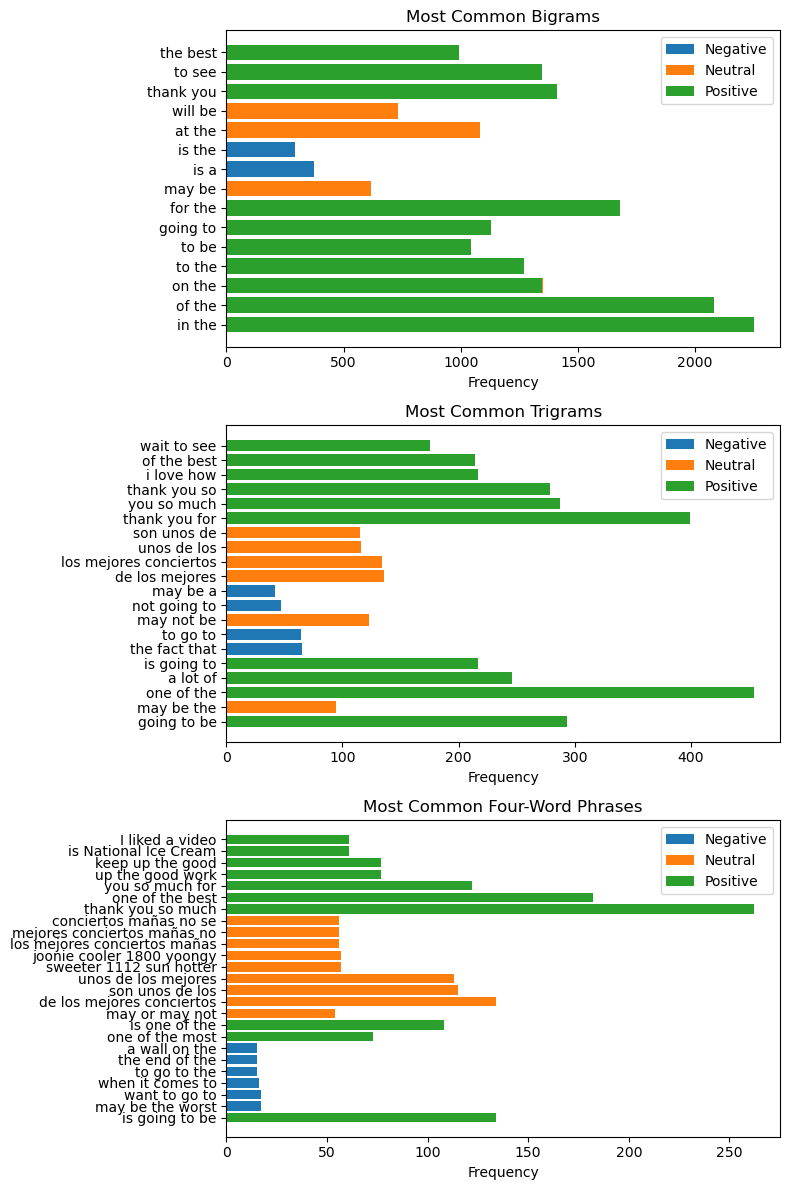

In [43]:
from collections import Counter
from itertools import islice

def get_ngrams(texts, n=3):
    ngrams = Counter()
    for text in texts:
        words = text.split()
        ngrams.update(zip(*[words[i:] for i in range(n)]))
    return ngrams.most_common(10)  

sentiment_groups = df.groupby("Sentiment")["Comment"].apply(list)
ngrams_data = {sent: {n: get_ngrams(texts, n) for n in [2, 3, 4]} for sent, texts in sentiment_groups.items()}

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
ngram_titles = ["Most Common Bigrams", "Most Common Trigrams", "Most Common Four-Word Phrases"]

for idx, n in enumerate([2, 3, 4]):
    ax = axes[idx]
    bigram_counts = {sentiment_labels[sent]: ngrams_data[sent][n] for sent in sentiment_labels.keys()}
    
    for sentiment, data in bigram_counts.items():
        phrases, counts = zip(*data) if data else ([], [])
        phrases = [" ".join(phrase) for phrase in phrases]  # Convert tuple to string
        ax.barh(phrases, counts, label=sentiment)
    
    ax.set_title(ngram_titles[idx])
    ax.set_xlabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()


There are no significant differences between phrases of different sentiments. So it may be hard to classify the comments based on the phrases. With the help of BERT, we can classify the comments more accurately.

## Data Preprocessing

In [45]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\davyd\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [46]:
class CommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length=128):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self, idx):
        text = str(self.comments[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [47]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df["Comment"], df["Sentiment"], test_size=0.1, random_state=42)

In [48]:
# Create dataset objects
train_dataset = CommentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = CommentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

In [49]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)